In [1]:
# Library of my own functions
import sys
sys.path.append("../../src/")
import my_functions

# Libraries to deal with dataframes, vectors and formats
import pandas as pd
import numpy as np
import pickle as pkl

# sklearn to do Grid Search & ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score 

# Imbalanced Learn
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Plotting libraries to understand the models
import matplotlib.pyplot as plt
import seaborn as sns
import logging
logging.getLogger().setLevel(logging.CRITICAL) # Avoids no critical warnings
plt.rcParams['figure.figsize'] = [20, 4] # Change figure size of the cell of the notebook

# 1. Train Model

##  1.1 Create Features and Target

In [2]:
df = pd.read_csv("../../data/breast_cancer/preprocess/breast_cancer_standard_scaler.csv", index_col="index")

# Variable Names
varnames = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

# Seeting Data types
df[varnames] = df[varnames].astype("float32")
df.diagnosis = df.diagnosis.astype("category")

# Split the data into train and validation sets
df_training, df_validation = df[df["split"] =="train"], df[df["split"] =="test"]
X_train, X_validation = df_training[varnames], df_validation[varnames]
y_train, y_validation = df_training["diagnosis"], df_validation["diagnosis"]

# Divide all data for predictions
X_all = df[varnames]

## 1.2 Create SMOTE

In [3]:
sm = SMOTE(random_state=1)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [4]:
ad = ADASYN(random_state=1)
X_adasyn, y_adasyn = ad.fit_resample(X_train, y_train)

In [5]:
bl = BorderlineSMOTE(random_state=1)
X_borderline, y_borderline = bl.fit_resample(X_train, y_train)

In [6]:
svm = SVMSMOTE(random_state=1)
X_svm, y_svm = svm.fit_resample(X_train, y_train)

In [7]:
ros = RandomOverSampler(random_state=1)
X_ros, y_ros = ros.fit_resample(X_train, y_train)


In [8]:
under = RandomUnderSampler(random_state=1)
X_under, y_under = under.fit_resample(X_train, y_train)

In [9]:
data_to_train = [(X_train, y_train, "STANDARD"), (X_smote, y_smote, "SMOTE"), (X_adasyn, y_adasyn, "ADASYN"), (X_borderline, y_borderline, "BORDERLINE"), (X_svm, y_svm, "SVM"), (X_ros, y_ros, "RANDOM"), (X_ros, y_ros, "UNDER")] 

## 2.2 Logistic Regression 

#### 2.2.1  Train

In [23]:
for i in data_to_train:
    X_loop = i[0]
    y_loop = i[1]
    name = i[2]

    path = "../../results/breast_cancer/Training/log_reg_" + name + ".csv"

    parameters = {
        'C'       : np.linspace(0.001,2,100),
    }

    name_logreg = LogisticRegression(random_state=1)

    grid_search = GridSearchCV(name_logreg,                    # model
                    param_grid = parameters,   # hyperparameters
                    scoring="f1_weighted",        # metric for scoring
                    cv=10,
                    return_train_score=True,
                    n_jobs=-1)      

    grid_search.fit(X_loop, y_loop)

    # Save Results 
    df = pd.DataFrame(grid_search.cv_results_)
    df.to_csv(path)

    # Save Model
    log_reg_best = grid_search.best_estimator_ # Best Model

    path = "../../models/breast_cancer/logistic_regression_" + name + ".pkl"
    with open(path,'wb') as f:
        pkl.dump(log_reg_best,f)

    # Logs
    try:
        y_pred = log_reg_best.predict(X_loop)
        train_error = f1_score(y_loop, y_pred, average="weighted")
        print("F1-weighted for: " + name)
        print("Training: " + str(train_error))
        print("Validation: " + str(grid_search.best_score_))
    except:
        print(name + " process")
    

F1-weighted for: STANDARD
Training: 0.9889908435436422
Validation: 0.982400884564791
F1-weighted for: SMOTE
Training: 0.9912278271789616
Validation: 0.9859497542578126
F1-weighted for: ADASYN
Training: 0.9732627118852905
Validation: 0.9553038304838555
F1-weighted for: BORDERLINE
Training: 0.9789471092287992
Validation: 0.9683907686189619
F1-weighted for: SVM
Training: 0.9754385964912281
Validation: 0.9701473191526203
F1-weighted for: RANDOM
Training: 0.9859642210758303
Validation: 0.9806681422652609
F1-weighted for: UNDER
Training: 0.9859642210758303
Validation: 0.9806681422652609


#### 2.2.3  Make predictions in all Dataset

In [41]:
# Make Predictions in all dataset
y_hat = rfecv.predict(X_all)

# Save it in the df
df["Predicted_logreg"] = y_hat

## 2.3 Random Forest

#### 2.3.1  Create Grid for Hyperparameter Selection

In [31]:
# Initialize Random Forest
model = RandomForestClassifier(random_state= 1)

# Hyperparameter Space
grid = {"max_depth":[5,10,20],
        "n_estimators":[i for i in range(10,100,10)],
        "min_samples_leaf":[i for i in range(1,10)],
        "criterion":["gini","entropy"],
        "max_features":["auto","sqrt","log2"]}

# Training        
for i in data_to_train:
    X_loop = i[0]
    y_loop = i[1]
    name = i[2]
    print(name)
    path = "../../results/breast_cancer/Training/random_forest_" + name + ".csv"

    random_search = RandomizedSearchCV(estimator= model,n_iter=300, param_distributions = grid, cv=10, scoring="f1_weighted", verbose=1, n_jobs= -1, return_train_score=1, random_state=1)

    random_search.fit(X_loop, y_loop)

    # Save Results 
    df = pd.DataFrame(random_search.cv_results_)
    df.to_csv(path)

    # Save Model
    rs_best = random_search.best_estimator_ # Best Model

    path = "../../models/breast_cancer/random_forest_" + name + ".pkl"
    with open(path,'wb') as f:
        pkl.dump(rs_best,f)

    # Log
    try:
        y_pred = rs_best.predict(X_loop)
        train_error = f1_score(y_loop, y_pred, average="weighted")
        print("F1-weighted for: " + name)
        print("Training: " + str(train_error))
        print("Validation: " + str(random_search.best_score_))
    except:
        print(name + " process")

STANDARD
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: STANDARD
Training: 0.9933945061261853
Validation: 0.9667903975080969
SMOTE
Fitting 10 folds for each of 300 candidates, totalling 3000 fits


/home/raul/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


F1-weighted for: SMOTE
Training: 0.9964911848714664
Validation: 0.977184322159047
ADASYN
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: ADASYN
Training: 1.0
Validation: 0.964286783548982
BORDERLINE
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: BORDERLINE
Training: 1.0
Validation: 0.9753756712400701
SVM
Fitting 10 folds for each of 300 candidates, totalling 3000 fits


/home/raul/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


F1-weighted for: SVM
Training: 1.0
Validation: 0.9754277776177351
RANDOM
Fitting 10 folds for each of 300 candidates, totalling 3000 fits


/home/raul/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


F1-weighted for: RANDOM
Training: 0.9964911848714664
Validation: 0.980692012803223
UNDER
Fitting 10 folds for each of 300 candidates, totalling 3000 fits


/home/raul/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


F1-weighted for: UNDER
Training: 0.9964911848714664
Validation: 0.980692012803223


#### 2.3.2  Train

In [5]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  8.6min
[Parallel(n_jobs=4)]: Done 1125 out of 1125 | elapsed: 11.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [None],
                         'max_features': [1, 10, 20, 30, 40],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [100, 300, 500, 1000, 2000]},
             scoring='f1_weighted', verbose=1)

#### 2.3.4  Make predictions in whole dataset

In [12]:
y_hat = rf_best.predict(X_all)

# Save it in the df
df["Predicted_RandomForest"] = y_hat

#### 2.3.5  Save the model

In [13]:
with open('../models/pima/standard_scaler/random_forest.pkl','wb') as f:
    pkl.dump(rf_best,f)

## 2.4 Gradient Boosting

#### 2.4.1  Create Grid for Hyperparameter Selection

In [28]:
model = GradientBoostingClassifier(random_state=1)

grid = {
            'n_estimators' : [10, 20, 50],
            'learning_rate': [0.01, 0.075, 0.005],
            'max_depth': [1, 2, 3, 4, 5],#
            'min_samples_leaf': [1, 5, 10,20, 50, 70],#
            'min_samples_split': [20, 30, 50, 100, 150], #
            'max_features': [ 0.3, 0.2, 0.1] #
            }


for i in data_to_train:
    X_loop = i[0]
    y_loop = i[1]
    name = i[2]
    print(name)
    path = "../../results/breast_cancer/Training/gradient_boosting_" + name + ".csv"

    random_search = RandomizedSearchCV(estimator= model,n_iter=100, param_distributions = grid, cv=10, scoring="f1_weighted", verbose=1, n_jobs= -1, return_train_score=1, random_state=1)

    random_search.fit(X_loop, y_loop)

    # Save Results 
    df = pd.DataFrame(random_search.cv_results_)
    df.to_csv(path)

    # Save Model
    rs_best = random_search.best_estimator_ # Best Model

    path = "../../models/breast_cancer/gradient_boosting_" + name + ".pkl"
    with open(path,'wb') as f:
        pkl.dump(rs_best,f)

    # Log
    try:
        y_pred = rs_best.predict(X_loop)
        train_error = f1_score(y_loop, y_pred, average="weighted")
        print("F1-weighted for: " + name)
        print("Training: " + str(train_error))
        print("Validation: " + str(random_search.best_score_))
    except:
        print(name + " process")

STANDARD
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: STANDARD
Training: 0.9824175824175824
Validation: 0.9625673368608878
SMOTE
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: SMOTE
Training: 0.9894736842105263
Validation: 0.9754234384683388
ADASYN
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: ADASYN
Training: 1.0
Validation: 0.9624487514267246
BORDERLINE
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: BORDERLINE
Training: 0.998245608635299
Validation: 0.9683799137174101
SVM
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: SVM
Training: 0.9964911848714664
Validation: 0.968378802235039
RANDOM
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: RANDOM
Training: 0.9964911848714664
Validation: 0.9754169527518959
UNDER
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-wei

#### 2.4.4  Make predictions in all data

In [20]:
y_hat = gbc_best.predict(X_all)

# Save it in the df
df["Predicted_GradientBoosting"] = y_hat

## 2.5 ADA Boosting

#### 2.5.1  Create Grid for Hyperparameter Selection

In [32]:
# Models and Base Estimator
dtc = DecisionTreeClassifier(random_state=1)
log_reg = LogisticRegression(random_state=1)

model = AdaBoostClassifier(random_state=1)

# Grid
grid = { "n_estimators": np.arange(10, 5000, 10),
                    "learning_rate": np.linspace(0.001, 1, 300),
                    "base_estimator":[dtc, log_reg],
                    "algorithm": ["SAMME", "SAMME.R"]
}

# Train
for i in data_to_train:
    X_loop = i[0]
    y_loop = i[1]
    name = i[2]
    print(name)
    path = "../../results/breast_cancer/Training/ada_boost_" + name + ".csv"

    random_search = RandomizedSearchCV(estimator= model,n_iter=100, param_distributions = grid, cv=10, scoring="f1_weighted", verbose=1, n_jobs= -1, return_train_score=1, random_state=1)

    random_search.fit(X_loop, y_loop)

    # Save Results 
    df = pd.DataFrame(random_search.cv_results_)
    df.to_csv(path)

    # Save Model
    rs_best = random_search.best_estimator_ # Best Model

    path = "../../models/breast_cancer/ada_boost_" + name + ".pkl"
    with open(path,'wb') as f:
        pkl.dump(rs_best,f)

    # Log
    try:
        y_pred = rs_best.predict(X_loop)
        train_error = f1_score(y_loop, y_pred, average="weighted")
        print("F1-weighted for: " + name)
        print("Training: " + str(train_error))
        print("Validation: " + str(random_search.best_score_))
    except:
        print(name + " process")

STANDARD
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: STANDARD
Training: 0.9736263736263736
Validation: 0.9737140942063032
SMOTE
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: SMOTE
Training: 0.9842104777176908
Validation: 0.9841942870072516
ADASYN
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: ADASYN
Training: 0.9875225988798021
Validation: 0.9660856468653526
BORDERLINE
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: BORDERLINE
Training: 0.9912278271789616
Validation: 0.9754212778944904
SVM
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: SVM
Training: 0.9719284421516604
Validation: 0.9683929351851569
RANDOM
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
F1-weighted for: RANDOM
Training: 0.9824559243573328
Validation: 0.9771615449160868
UNDER
Fitting 10 folds for each of 100 candidates, totalling

#### 2.5.4  Make predictions in training and validation

In [27]:
y_hat = gs_ada_best.predict(X_all)

# Save it in the df
df["Predicted_AdaBoost"] = y_hat

## 2.6 SVC

#### 2.6.1  Create Grid for Hyperparameter Selection

In [12]:
# Initialize Random Forest
model = SVC(probability=True)

grid = {'kernel': ['rbf'], 
        'gamma': [ 0.001, 0.01, 0.1, 1],
        'C': [1, 10, 50, 100, 200,300, 1000]}

# Training        
for i in data_to_train:
    X_loop = i[0]
    y_loop = i[1]
    name = i[2]
    print(name)
    path = "../../results/breast_cancer/Training/svc_" + name + ".csv"

    random_search = GridSearchCV(estimator= model, param_grid = grid, cv=10, scoring="f1_weighted", verbose=1, n_jobs= -1, return_train_score=1)

    random_search.fit(X_loop, y_loop)

    # Save Results 
    df = pd.DataFrame(random_search.cv_results_)
    df.to_csv(path)

    # Save Model
    rs_best = random_search.best_estimator_ # Best Model

    path = "../../models/breast_cancer/svc_" + name + ".pkl"
    with open(path,'wb') as f:
        pkl.dump(rs_best,f)

    # Log
    try:
        y_pred = rs_best.predict(X_loop)
        train_error = f1_score(y_loop, y_pred, average="weighted")
        print("F1-weighted for: " + name)
        print("Training: " + str(train_error))
        print("Validation: " + str(random_search.best_score_))
    except:
        print(name + " process")

STANDARD
Fitting 10 folds for each of 28 candidates, totalling 280 fits
F1-weighted for: STANDARD
Training: 0.9889767597749427
Validation: 0.9845511543791534
SMOTE
Fitting 10 folds for each of 28 candidates, totalling 280 fits
F1-weighted for: SMOTE
Training: 1.0
Validation: 0.9859562519836086
ADASYN
Fitting 10 folds for each of 28 candidates, totalling 280 fits
F1-weighted for: ADASYN
Training: 1.0
Validation: 0.9857769423558898
BORDERLINE
Fitting 10 folds for each of 28 candidates, totalling 280 fits
F1-weighted for: BORDERLINE
Training: 0.998245608635299
Validation: 0.9912248263184926
SVM
Fitting 10 folds for each of 28 candidates, totalling 280 fits
F1-weighted for: SVM
Training: 0.998245608635299
Validation: 0.9824464007655843
RANDOM
Fitting 10 folds for each of 28 candidates, totalling 280 fits
F1-weighted for: RANDOM
Training: 0.998245608635299
Validation: 0.9877095586603211
UNDER
Fitting 10 folds for each of 28 candidates, totalling 280 fits
F1-weighted for: UNDER
Training: 0.9

#### 2.6.2  Train the model

In [31]:
gs_sv.fit(X_train, y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 273 out of 280 | elapsed:   20.3s remaining:    0.5s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   20.9s finished


GridSearchCV(cv=10, estimator=SVC(probability=True), n_jobs=4,
             param_grid={'C': [1, 10, 50, 100, 200, 300, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [32]:
# Best Model
sv_best = gs_sv.best_estimator_

# Best score
gs_sv.best_score_

0.7765897973445142

#### 2.6.3  Make predictions in training and validation

In [33]:
y_hat = sv_best.predict(X_all)

# Save it in the df
df["Predicted_SupportVectorClassifier"] = y_hat

#### 2.6.4  Save the model

In [34]:
with open('../models/pima/standard_scaler/svc.pkl','wb') as f:
    pkl.dump(sv_best,f)

## Save Final df

In [36]:
df.to_csv("../data/predictions/pima/standard_scaler/predictions_9june.csv")

## 2.7 Deep Learning 

I try to do a deep learning approach also because I really like Deep Learning. I even made the whole specialization of Deep Learning in Coursera (100 hours) and my master thesis was about classifying different Respiratory Sounds with DL.

However, there is a problem in the way I have to encode the data to feed it to the model. I did the one fitting, but the model was not learning anything. I put the code so you can evaluate that I can also use Keras and TensorFlow.

#### 2.7.1 Create the Model

In [12]:
# Create the model
input_dim = X_train.shape[1]

model = Sequential(
    [
        Dense(256, activation="relu", input_shape=(input_dim,)),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(2, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               12288     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 514       
Total params: 144,386
Trainable params: 144,386
Non-trainable params: 0
________________________________________________

In [13]:
optimizer = Adam(lr=0.000001)
auc = tf.keras.metrics.AUC()
metrics = ['accuracy', auc] 
loss_function = 'binary_crossentropy'

# Compile model
model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

#### 2.7.2 Train the model

In [14]:
# Establishing Callbacks
csv_logger = CSVLogger("../models/deep_learning/history.csv", append=True) 
checkpoint = ModelCheckpoint("../models/deep_learning/dl_model.h5", monitor='val_auc_1', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') 
early_stopping = EarlyStopping(monitor='val_auc', min_delta=0, patience=20, verbose=1, mode='auto')

In [6]:
epochs = 500 # Number of epochs to train (We put this number high, because we have the early stopping callback)
model.fit(X_train, y_train, validation_data = (X_val, y_val), callbacks = [csv_logger, checkpoint, early_stopping], epochs=epochs)

#### 2.7.3 Evaluate the Training

In [16]:
input_file = "../models/deep_learning/history.csv"
history = pd.read_csv(input_file)

# Tidy the df so it become easier to plot
history['epoch'] = history.index
history = pd.melt(history, id_vars=['epoch'])
history.rename(columns={"variable":"metric"},inplace=True)

Text(0.5, 1.0, 'Loss Plot')

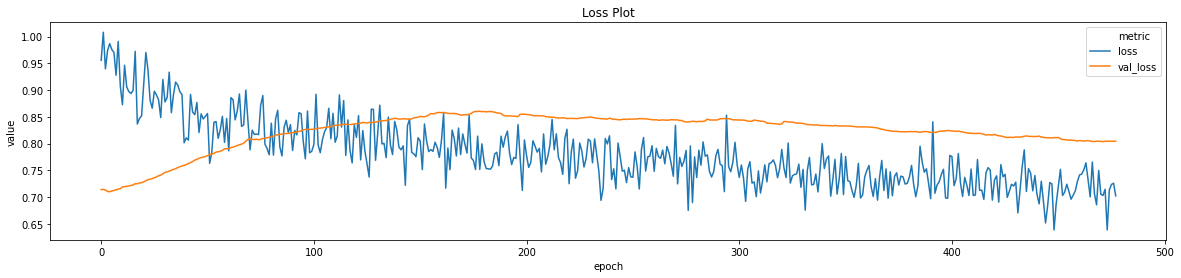

In [18]:
# Loss Plot
loss_df = history[history['metric'].isin(['val_loss','loss'])]
sns.lineplot(x='epoch', y='value', hue='metric', data=loss_df)
plt.title("Loss Plot")

-The value of val_loss and loss is increasing while it must decrease that why I said it is not learning. The same happens with accuracy and auc, they remain flat

## XGBoost

In [27]:
import xgboost as xgb
from hyperopt import hp
from sklearn.preprocessing import LabelEncoder

In [28]:
# Initiate Label Encoder
le = LabelEncoder()

# Model
model = xgb.XGBClassifier()

# Ggrid
grid=params = {
    "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [ 1, 3, 5, 7 ],
    "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}


# Train
for i in data_to_train:
    X_loop = i[0]
    y_loop = i[1]
    name = i[2]
    print(name)
    path = "../../results/breast_cancer/Training/xgboost_" + name + ".csv"

    # Converting y_loop so it can be fit by XGB
    y_loop = le.fit_transform(y_loop)

    random_search = RandomizedSearchCV(estimator= model,n_iter=300, param_distributions = grid, cv=10, scoring="f1_weighted", verbose=1, n_jobs= -1, return_train_score=1, random_state=1)

    random_search.fit(X_loop, y_loop)

    # Save Results 
    df = pd.DataFrame(random_search.cv_results_)
    df.to_csv(path)

    # Save Model
    rs_best = random_search.best_estimator_ # Best Model

    path = "../../models/breast_cancer/xgboost_" + name + ".pkl"
    with open(path,'wb') as f:
        pkl.dump(rs_best,f)

    # Log
    try:
        y_pred = rs_best.predict(X_loop)
        train_error = f1_score(y_loop, y_pred, average="weighted")
        print("F1-weighted for: " + name)
        print("Training: " + str(train_error))
        print("Validation: " + str(random_search.best_score_))
    except:
        print(name + " process")

STANDARD
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: STANDARD
Training: 0.9978008807263491
Validation: 0.9757626665333342
SMOTE
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: SMOTE
Training: 1.0
Validation: 0.9806811799229284
ADASYN
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: ADASYN
Training: 1.0
Validation: 0.9803507019296493
BORDERLINE
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: BORDERLINE
Training: 1.0
Validation: 0.98595409140976
SVM
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: SVM
Training: 1.0
Validation: 0.980685517074876
RANDOM
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: RANDOM
Training: 1.0
Validation: 0.9824474800537839
UNDER
Fitting 10 folds for each of 300 candidates, totalling 3000 fits
F1-weighted for: UNDER
Training: 1.0
Validation: 0.9824474800537839